In [17]:
import sys
#change to match where the PmagPy folder is on your computer
sys.path.insert(0, '/Users/Laurentia/PmagPy')
import pmag,pmagplotlib,ipmag # import PmagPy functions

import pmag
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The function below, tk03, is the TK03.py program of PmagPy modified for use in the notebook environment. This function is within ipmag and is shown below for documentation sake. This function calls upon the mktk03 function of the pmag.py module in order to generate the gauss coefficients from the tk03 model from which the declination/inclination are calculated using the getvec (which itself uses the magsyn function).

In [18]:
def tk03(n=100,dec=0,lat=0,rev='no',G2=0,G3=0):
    """
    generates set of vectors drawn from the TK03.gad model of 
    secular variation (Tauxe and Kent, 2004) at given latitude and rotated 
    about a vertical axis by the given declination 

    Arguments
    ----------
    n number of vectors to determine (default is 100)
    dec mean declination of data set (default is 0)
    lat latitude at which secular variation is simulated (default is 0)
    rev if reversals are to be included this should be 'yes' (default is 'no')
    G2 specify average g_2^0 fraction (default is 0)
    G3 specify average g_3^0 fraction (default is 0)
    """
    tk_03_output=[]
    for k in range(n): 
        gh=pmag.mktk03(8,k,G2,G3) # terms and random seed
        long=random.randint(0,360) # get a random longitude, between 0 and 359
        vec= pmag.getvec(gh,lat,long)  # send field model and lat to getvec
        vec[0]+=dec
        if vec[0]>=360.:
            vec[0]-=360.
        if k%2==0 and rev=='yes':
           vec[0]+=180.
           vec[1]=-vec[1]
        tk_03_output.append([vec[0],vec[1],vec[2]])    
    return tk_03_output

In the code block below, the tk03 function is used to generate populations of directions at a range of latitudes (entered as inclination and then converted to latitude so that the spacing is equal in the elongation vs inclination plot). From these tk03 generated populations, the elongation is calculated as the ratio of the intermediate and smallest eigenvalues of the orientation matrix ($\tau_2/\tau_3$).

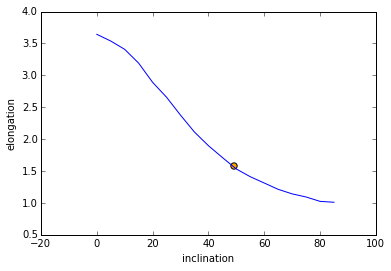

In [60]:
elongation = []
inclination = []

for inc in range(0,90,5):
    latitude = ipmag.lat_from_inc(inc)
    TK03_array = tk03(n=50000,lat=latitude)
    ppars = pmag.doprinc(TK03_array)
    elong = ppars['tau2']/ppars['tau3']
    elongation.append(elong)
    inclination.append(inc)
    
plt.plot(inclination, elongation)
plt.xlabel('inclination')
plt.ylabel('elongation')
plt.show()

Tauxe et al. (2007) reported the best fit coefficients for the E/I equation ($E = a + bI + cI^{2} + dI^{3}$) for the TK03 model to be

| a | b | c | d |

TK03.GAD | 2.895 | -1.466e-2 | -3.525e-4 | 3.160e-06 |

TK03.G20 | 2.842 | -5.961e-3 | -1.694e-4 | 1.244e-07 |

In the plot below, the line resulting from this best fit polynomial is shown in comparision to the elongation vs inclination resulting from the analysis of the populations created using the TK03 function above. Additionally, to check the implementation of the TK03 function above and the calculated elongation values, the tk03.py program was run at the command line generating 100,000 draws from the model at latitudes of 0, 30 and 80. Elongation is calculated for those model output vectors in the code block below and they are plotted for comparision.

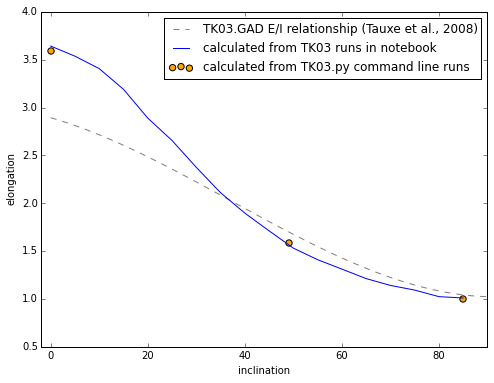

In [67]:
elongation_cl = []
inclination_cl = []

TK03_lat0 = np.loadtxt('TK03_EI/TK03_commandline_lat0.txt')
ppars = pmag.doprinc(TK03_lat0)
elongation_cl.append(ppars['tau2']/ppars['tau3'])
inclination_cl.append(ipmag.inc_from_lat(0))

TK03_lat30 = np.loadtxt('TK03_EI/TK03_commandline_lat30.txt')
ppars = pmag.doprinc(TK03_lat30)
elongation_cl.append(ppars['tau2']/ppars['tau3'])
inclination_cl.append(ipmag.inc_from_lat(30))

TK03_lat80 = np.loadtxt('TK03_EI/TK03_commandline_lat80.txt')
ppars = pmag.doprinc(TK03_lat80)
elongation_cl.append(ppars['tau2']/ppars['tau3'])
inclination_cl.append(ipmag.inc_from_lat(80))

xa = np.linspace(0,90,num=90)
TK03GAD = 2.895 + -1.466e-2*xa + -3.525e-4*xa**2 + 3.160e-6*xa**3

plt.figure(figsize=(8,6))
plt.plot(xa,TK03GAD,color='grey',linestyle='--',label='TK03.GAD E/I relationship (Tauxe et al., 2008)')
plt.plot(inclination, elongation,'b-',label='calculated from TK03 runs in notebook')
plt.scatter(inclination_cl,elongation_cl,s=40,c='orange',label='calculated from TK03.py command line runs')
plt.xlabel('inclination')
plt.ylabel('elongation')
plt.xlim(-2,90)
plt.legend()
plt.show()

49.1066053509
1.5833945098


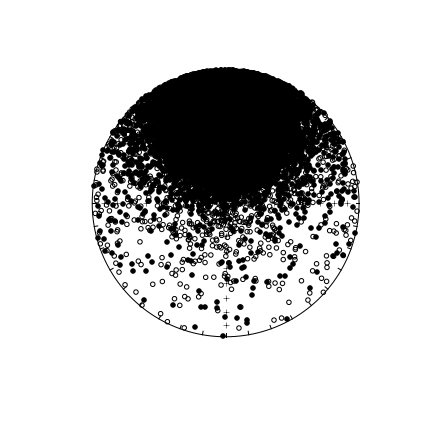

In [40]:
TK03_lat0 = np.loadtxt('TK03_EI/TK03_commandline_lat30.txt')
ppars = pmag.doprinc(TK03_lat0)
elongation = ppars['tau2']/ppars['tau3']
inclination = ipmag.inc_from_lat(30)
print inclination
print elongation

fignum = 1
plt.figure(num=fignum,figsize=(6,6),dpi=160)
ipmag.plot_net(1)
ipmag.plot_di(TK03_lat0[:,0],TK03_lat0[:,1])
plt.show()

In [2]:
def elong_calc2(data):
    rad=numpy.pi/180.
    Es = []
    ppars=pmag.doprinc(data)
    Es.append(ppars["tau2"]/ppars["tau3"])
    return Es

In [2]:
def elong_calc(DIblock):
    #convert to cartesian
    DI_cart = pmag.dir2cart(DIblock)
    #create T matrix
    #Could use the function from pmag: pmag.Tmatrix(Umk_cart_cart),...
    #...however I don't know what the input should be, so did manually...
    #...according to Tanaka (1999)
    T_matrix = [[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
    T_matrix[0][0] = np.sum((DI_cart[:,0]**2))
    T_matrix[0][1] = np.sum((DI_cart[:,0]*DI_cart[:,1]))
    T_matrix[1][0] = np.sum((DI_cart[:,0]*DI_cart[:,1]))
    T_matrix[1][1] = np.sum((DI_cart[:,1]**2))
    T_matrix[0][2] = np.sum((DI_cart[:,0]*DI_cart[:,2]))
    T_matrix[2][0] = np.sum((DI_cart[:,0]*DI_cart[:,2]))
    T_matrix[1][2] = np.sum((DI_cart[:,1]*DI_cart[:,2]))
    T_matrix[2][1] = np.sum((DI_cart[:,1]*DI_cart[:,2]))
    T_matrix[2][2] = np.sum((DI_cart[:,2]**2))
    #calculate eigenvalues and eigenvectors for the T matrix
    eigvalues = pmag.tauV(T_matrix)
    t1 = eigvalues[0][0]
    t2 = eigvalues[0][1]
    t3 = eigvalues[0][2]
    elong = t2/t3
    return elong

In [4]:
def tk03(n=100,dec=0,lat=0,rev='no',G2=0,G3=0):
    """
    generates set of vectors drawn from the TK03.gad model of 
    secular variation (Tauxe and Kent, 2004) at given latitude and rotated 
    about a vertical axis by the given declination 

    Arguments
    ----------
    n number of vectors to determine (default is 100)
    dec mean declination of data set (default is 0)
    lat latitude at which secular variation is simulated (default is 0)
    rev if reversals are to be included this should be 'yes' (default is 'no')
    G2 specify average g_2^0 fraction (default is 0)
    G3 specify average g_3^0 fraction (default is 0)
    """
    tk_03_output=[]
    for k in range(n): 
        gh=pmag.mktk03(8,k,G2,G3) # terms and random seed
        long=random.randint(0,360) # get a random longitude, between 0 and 359
        vec= pmag.getvec(gh,lat,long)  # send field model and lat to getvec
        vec[0]+=dec
        if vec[0]>=360.:
            vec[0]-=360.
        if k%2==0 and rev=='yes':
           vec[0]+=180.
           vec[1]=-vec[1]
        tk_03_output.append([vec[0],vec[1],vec[2]])    
    return tk_03_output

In [5]:
elongation_GAD = []
inclination_GAD = []
for latitude in range(0,90,2):
    data = tk03(200000,dec=0,lat=latitude,G3=0)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_GAD.append(elong) 
    inclination_GAD.append(inc)

KeyboardInterrupt: 

In [ ]:
print elongation_GAD

In [ ]:
plt.plot(inclination_GAD,elongation_GAD,'k.-')

In [8]:
elongation_G3_20 = []
inclination_G3_20 = []
for latitude in range(0,90,2):
    data = tk03(2000,dec=0,lat=latitude,G3=.2)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_G3_20.append(elong) 
    inclination_G3_20.append(inc)

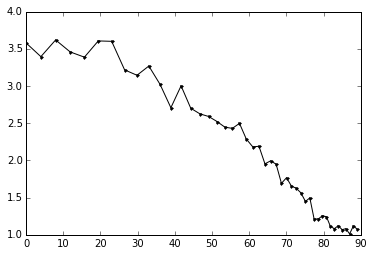

In [9]:
plt.plot(inclination_G3_20,elongation_G3_20,'k.-')

In [15]:
elongation_G2_10 = []
inclination_G2_10 = []
for latitude in range(0,90,2):
    data = tk03(2000,dec=0,lat=latitude,G2=10)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_G2_10.append(elong) 
    inclination_G2_10.append(inc)

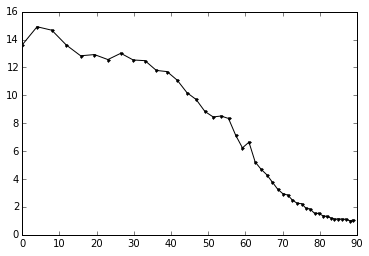

In [16]:
plt.plot(inclination_G2_10,elongation_G2_10,'k.-')